In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np

In [ ]:
imgNames[0].split(')')[0]

'benign (10'

In [ ]:
class_label={'malignant':0,'benign':1}

In [ ]:
framObjTrain = {'img' : [],
           'mask' : [],
           'class':[]
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    class_names=[]
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])
        class_names.append(imgNames[i].split(' ')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))

        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        frameObj['class'].append(class_label[class_names[i]])
        
    return frameObj

In [ ]:
framObjTrain = LoadData(framObjTrain, 
                    imgPath = '/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/benign',
                    maskPath = '/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/benign',
                    shape = 256)
framObjTrain = LoadData(framObjTrain, 
                    imgPath = '/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/malignant',
                    maskPath = '/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/malignant',
                    shape = 256)
# framObjTrain = LoadData(framObjTrain, 
#                     imgPath = '/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/combined data',
#                     maskPath = '/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/combined data',
#                     shape = 256)

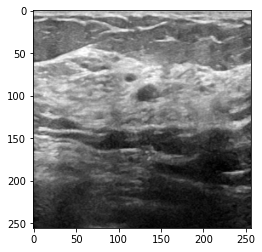

In [ ]:
plt.imshow(framObjTrain['img'][3])


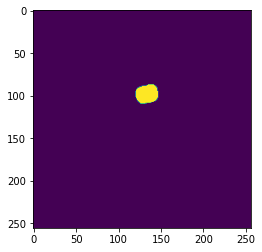

In [ ]:
plt.imshow(framObjTrain['mask'][3])

In [ ]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def MakeUnetModel(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [ ]:
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = MakeUnetModel(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/best_breast_cancer_model.hdf5'

In [ ]:
from tensorflow.keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 30; batch_size = 32
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, 
                                   verbose=1, epsilon=0.0001)
early = EarlyStopping(monitor="val_accuracy", verbose=1,
                      patience=5)

In [ ]:
callbacks = [checkpoint, reduceLROnPlat, early]

In [ ]:
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 30, verbose = 1, callbacks=callbacks)

Epoch 1/30
21/21 [==============================] - 26s 426ms/step - loss: 0.5660 - accuracy: 0.7790 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 7s 339ms/step - loss: 0.4036 - accuracy: 0.9094 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 7s 341ms/step - loss: 0.3669 - accuracy: 0.9130 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 7s 342ms/step - loss: 0.3457 - accuracy: 0.9142 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 7s 343ms/step - loss: 0.3261 - accuracy: 0.9155 - lr: 0.0010
Epoch 6/30
21/21 [==============================] - 7s 345ms/step - loss: 0.2971 - accuracy: 0.9201 - lr: 0.0010
Epoch 7/30
21/21 [==============================] - 7s 346ms/step - loss: 0.2678 - accuracy: 0.9282 - lr: 0.0010
Epoch 8/30
21/21 [==============================] - 7s 350ms/step - loss: 0.2514 - accuracy: 0.9304 - lr: 0.0010
Epoch 9/30
21/21 [==============================] - 7s 350ms/step - loss: 0.2346 - accuracy: 0.

In [ ]:
cancer_classifier_model=keras.models.Sequential([
                                             keras.layers.Conv2D(filters=16,kernel_size=(7,7),strides=(3,3),activation='relu',padding='valid',input_shape=[256,256, 3]),
                                             keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same'),
                                             keras.layers.BatchNormalization(),
                                             keras.layers.Conv2D(filters=8,kernel_size=(5,5),strides=(2,2),activation='relu',padding='valid'),
                                             keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same'),
                                             keras.layers.Flatten(),
                                             keras.layers.Dense(300,activation='relu'),
                                             keras.layers.Dropout(0.5),
                                             keras.layers.BatchNormalization(),
                                             keras.layers.Dense(100,activation='relu'),
                                             keras.layers.Dropout(0.2),
                                             keras.layers.BatchNormalization(),
                                             keras.layers.Dense(10,activation='relu'),
                                            
                                             keras.layers.BatchNormalization(),
                                             keras.layers.Dense(2,activation='softmax'),
])

In [ ]:
cancer_classifier_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 84, 84, 16)        2368      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 42, 42, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_28 (Bat  (None, 42, 42, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 19, 19, 8)         3208      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 10, 10, 8)        0         
 g2D)                                                            
                                                      

In [ ]:
cancer_classifier_model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
callback_seq=keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/cancer_classifier_model.h5", save_best_only=True)

In [ ]:
history=cancer_classifier_model.fit(np.array(framObjTrain['img']),np.array(framObjTrain['class']),epochs=30,callbacks=[callback_seq])

Epoch 1/30
21/21 [==============================] - 2s 23ms/step - loss: 0.9361 - accuracy: 0.5518
Epoch 2/30
21/21 [==============================] - 0s 20ms/step - loss: 0.7195 - accuracy: 0.6723
Epoch 3/30
21/21 [==============================] - 0s 20ms/step - loss: 0.5955 - accuracy: 0.7094
Epoch 4/30
21/21 [==============================] - 0s 20ms/step - loss: 0.5685 - accuracy: 0.7218
Epoch 5/30
21/21 [==============================] - 0s 19ms/step - loss: 0.5690 - accuracy: 0.7388
Epoch 6/30
21/21 [==============================] - 0s 20ms/step - loss: 0.5167 - accuracy: 0.7728
Epoch 7/30
21/21 [==============================] - 0s 20ms/step - loss: 0.4616 - accuracy: 0.7883
Epoch 8/30
21/21 [==============================] - 0s 20ms/step - loss: 0.4669 - accuracy: 0.7929
Epoch 9/30
21/21 [==============================] - 0s 20ms/step - loss: 0.4299 - accuracy: 0.8145
Epoch 10/30
21/21 [==============================] - 0s 20ms/step - loss: 0.4426 - accuracy: 0.8114
Epoch 11/

In [ ]:
def predict (breastImgPath, model, shape = 256):
    ## getting and proccessing val data
    img=plt.imread(breastImgPath)
    img = cv2.resize(img, (shape, shape)) 

    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc

In [ ]:
mask_img,actual_img=predict('/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/malignant/malignant (1).png',myTransformer)
plt.imshow(mask_img)

ValueError: ignored

In [ ]:
temp=plt.imread('/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/malignant/malignant (1).png')

In [ ]:
temp.shape

(598, 449, 3)

In [ ]:
temp = cv2.resize(temp, (256, 256)) 
temp.shape

(256, 256, 3)

In [ ]:
temp1=np.array(temp)

In [ ]:
len(temp1)

256

In [ ]:
pre=myTransformer.predict(temp)

ValueError: ignored

In [ ]:
myTransformer.save('/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/BreastCancerSegmentor.h5')

In [ ]:
model_cancer = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/BreastCancerSegmentor.h5')

In [ ]:
model_cancer_class=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/classifier_cancer_breast.h5')

In [ ]:
def image_segmenter(imgpath):
  img=plt.imread(imgpath)
  img=cv2.resize(img,(256,256))
  img=np.expand_dims(img,axis=0)
  affected_tissue=model_cancer.predict(np.array(img))
  class_cancer=model_cancer_class.predict(np.array(img))
  return affected_tissue,class_cancer

In [ ]:
cancer_classifier_model.save('/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/classifier_cancer_breast.h5')

In [ ]:
segmented,cls=image_segmenter('/content/drive/MyDrive/Colab Notebooks/Dataset_BUSI_with_GT/benign/benign (10).png')

In [ ]:
cls.argmax()

1

1


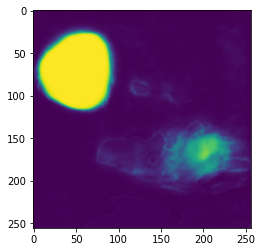

In [ ]:
plt.imshow(segmented[0][:,:,0])
print(cls.argmax())